# Data Exploration, Smoothing and Expansion
This Notebook covers the first steps taken to load and understand Mass Spectronomy Data (.mzML)

## Data Exploration

In [1]:
# Import necessary libraries
from pyopenms import MSExperiment, MzMLFile
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Define functions for loading data, converting 
# to DataFrame, and plotting spectra

# Function to load mzML file
def load_mzml_file(file_path):
    experiment = MSExperiment()
    MzMLFile().load(file_path, experiment)
    return experiment

# Function to convert data to DataFrame
def convert_to_dataframe(experiment):
    df = experiment.get_df()
    return df

# Function to plot spectrum
def plot_spectrum(df, index):
    plt.figure(figsize=(10, 6))
    plt.stem(df.iloc[index]['mzarray'], df.iloc[index]['intarray'], linefmt="grey", markerfmt="D", basefmt="black")
    plt.title(f'Spectrum at Retention Time = {df.iloc[index]["RT"]}')
    plt.xlabel('m/z')
    plt.ylabel('Intensity')
    plt.show()


In [3]:
# Load the mzML file

file_path = "C:\\Users\\victo\\VSCode Folder\\UMCG Mass Spec\\3_2_extract_overlap_1.mzML"
experiment = load_mzml_file(file_path)

In [4]:
# Convert the loaded data to a DataFrame
df = convert_to_dataframe(experiment)

# Display DataFrame statistics
print(df.describe())

                RT
count   161.000000
mean   3046.764740
std      37.489931
min    2982.788700
25%    3014.804700
50%    3042.811020
75%    3079.571760
max    3112.435440


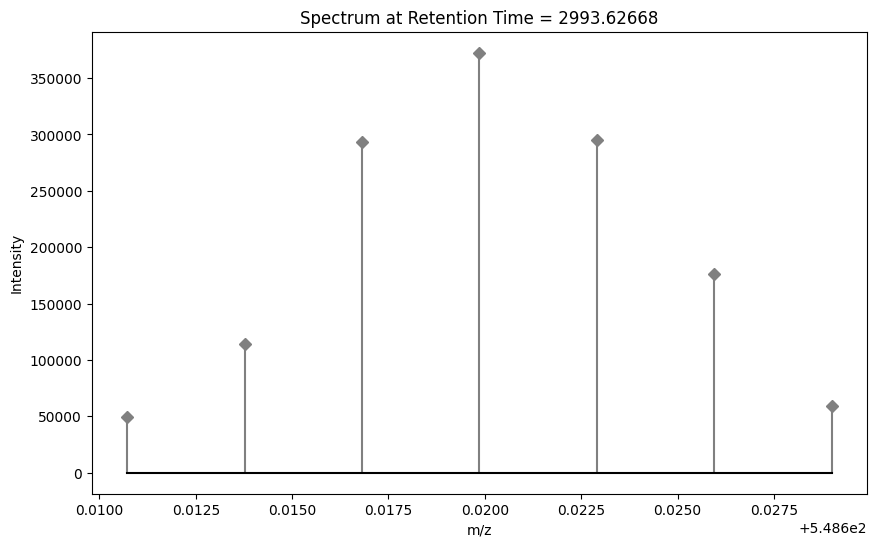

In [5]:
# Plot a specific spectrum
plot_spectrum(df, 10)


## Data Smoothing

In [6]:
# Import necessary libraries for data expansion
from scipy.ndimage import gaussian_filter1d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [7]:
# Function to apply Gaussian smoothing
def apply_gaussian_smoothing(array, sigma):
    return gaussian_filter1d(array, sigma)

In [8]:
# Apply Gaussian smoothing to intensity data and create a new DataFrame

df["Smoothed INT"] = df["intarray"].apply(lambda x: apply_gaussian_smoothing(np.array(x), sigma=2))

print(df.head())

# Isolate Smoothed INT column
smoothed = df["Smoothed INT"]

# Create an empty DataFrame for smoothed intensity values
smoothed_int_df = pd.DataFrame()

# Fill new DataFrame columns with smoothed array values
for i in range(len(smoothed[0])):
    smoothed_int_df[f"INT {i}"] = [entry[i] for entry in smoothed]

smoothed_int_df.index.name = "Spectrum NR"
print(smoothed_int_df)


           RT                                            mzarray  \
0  2982.78870  [548.6595438612912, 548.6625912113475, 548.665...   
1  2983.20168  [548.6137949054772, 548.61684187451, 548.61988...   
2  2984.01666  [548.6138211331556, 548.6168681023341, 548.619...   
3  2985.14556  [548.6138475127875, 548.6168944821125, 548.619...   
4  2987.20332  [548.6107912053993, 548.6138381492885, 548.616...   

                                            intarray  \
0  [48871.57, 93090.67, 119617.8, 105596.12, 5844...   
1  [59790.492, 110884.73, 140389.9, 125135.02, 77...   
2  [46852.145, 96281.12, 124956.57, 108827.82, 62...   
3  [54953.508, 96425.24, 116641.32, 97879.38, 541...   
4  [60526.164, 89810.484, 101158.25, 86533.97, 50...   

                                        Smoothed INT  
0  [80987.875, 83860.414, 86725.17, 87377.484, 86...  
1  [96185.88, 98356.7, 98479.66, 92976.91, 83411....  
2  [82655.03, 86008.39, 89535.695, 90712.586, 902...  
3  [82780.46, 84467.55, 85519.55, 

In [9]:
# Calculate percentage changes and determine thresholds for intensity data

# Calculate percentage increase from entry 1 to entry 4
increase = ((smoothed_int_df["INT 4"] - smoothed_int_df["INT 0"]) / smoothed_int_df["INT 0"]) * 100
smoothed_int_df["% Change"] = increase

# print(smoothed_int_df)

# Thresholds based on Q1, Median, and Q3: 25%: 26.290215 | 50%: 64.068970 | 75%: 155.69978
thresholds_int = [0, 26.290215, 64.068970, 155.699783]

# Categorize percentage change into bins
smoothed_int_df["Change Intensity"] = pd.cut(abs(smoothed_int_df["% Change"]), bins=thresholds_int, labels=["Low", "Medium", "High"])
smoothed_int_df["Change Intensity"] = smoothed_int_df["Change Intensity"].astype(str)

# Add a conditional (N) representing a negative change
smoothed_int_df.loc[smoothed_int_df["% Change"] < 0, "Change Intensity"] += "(N)"

# Descriptive statistics
print(smoothed_int_df["% Change"].describe())
print(smoothed_int_df)


count    161.000000
mean     102.206398
std      110.621155
min      -19.104771
25%       26.290215
50%       64.068970
75%      155.699783
max      661.169434
Name: % Change, dtype: float64
                    INT 0         INT 1         INT 2          INT 3  \
Spectrum NR                                                            
0            80987.875000  83860.414062  86725.171875   87377.484375   
1            96185.882812  98356.703125  98479.656250   92976.906250   
2            82655.031250  86008.390625  89535.695312   90712.585938   
3            82780.460938  84467.546875  85519.546875   84495.468750   
4            78799.765625  79312.671875  78900.546875   76950.000000   
...                   ...           ...           ...            ...   
156          62020.082031  75850.296875  96103.992188  111552.523438   
157          51944.808594  51944.605469  51603.730469   51456.527344   
158          58827.125000  60639.859375  63296.109375   67287.078125   
159          4626

In [10]:
# Apply Gaussian smoothing to m/z data and create a new DataFrame

df["Smoothed MZ"] = df["mzarray"].apply(lambda x: apply_gaussian_smoothing(np.array(x), sigma=2))

print(df.head())

smoothed = df["Smoothed MZ"]
# Create an empty DataFrame for smoothed m/z values
smoothed_mz_df = pd.DataFrame()

# Fill new DataFrame columns with smoothed array values
for i in range(len(smoothed[0])):
    smoothed_mz_df[f"MZ {i}"] = [entry[i] for entry in smoothed]

smoothed_mz_df.index.name = "Spectrum NR"

print(smoothed_mz_df)


           RT                                            mzarray  \
0  2982.78870  [548.6595438612912, 548.6625912113475, 548.665...   
1  2983.20168  [548.6137949054772, 548.61684187451, 548.61988...   
2  2984.01666  [548.6138211331556, 548.6168681023341, 548.619...   
3  2985.14556  [548.6138475127875, 548.6168944821125, 548.619...   
4  2987.20332  [548.6107912053993, 548.6138381492885, 548.616...   

                                            intarray  \
0  [48871.57, 93090.67, 119617.8, 105596.12, 5844...   
1  [59790.492, 110884.73, 140389.9, 125135.02, 77...   
2  [46852.145, 96281.12, 124956.57, 108827.82, 62...   
3  [54953.508, 96425.24, 116641.32, 97879.38, 541...   
4  [60526.164, 89810.484, 101158.25, 86533.97, 50...   

                                        Smoothed INT  \
0  [80987.875, 83860.414, 86725.17, 87377.484, 86...   
1  [96185.88, 98356.7, 98479.66, 92976.91, 83411....   
2  [82655.03, 86008.39, 89535.695, 90712.586, 902...   
3  [82780.46, 84467.55, 85519.

In [11]:
# Calculate percentage changes and determine thresholds for m/z data

# Calculate percentage increase from entry 1 to entry 4
increase = ((smoothed_mz_df["MZ 4"] - smoothed_mz_df["MZ 0"]) / smoothed_mz_df["MZ 0"]) * 100
smoothed_mz_df["% Change"] = increase

# Thresholds based on Q1, Median, and Q3: 25%: 0.001549 | 50%: 0.001584 | 75%: 0.001709
thresholds_mz = [0, 0.001549, 0.001584, 0.001709]

# Categorize percentage change into bins
smoothed_mz_df["Change Intensity"] = pd.cut(abs(smoothed_mz_df["% Change"]), bins=thresholds_mz, labels=["Low", "Medium", "High"])
smoothed_mz_df["Change Intensity"] = smoothed_mz_df["Change Intensity"].astype(str)

# Add a conditional (N) representing a negative change
smoothed_mz_df.loc[smoothed_mz_df["% Change"] < 0, "Change Intensity"] += "(N)"

# Descriptive Statistics
print(smoothed_mz_df["% Change"].describe())
print(smoothed_mz_df)


count    161.000000
mean       0.001889
std        0.001164
min        0.000955
25%        0.001549
50%        0.001584
75%        0.001709
max        0.011236
Name: % Change, dtype: float64
                   MZ 0        MZ 1        MZ 2        MZ 3        MZ 4  \
Spectrum NR                                                               
0            548.663017  548.664019  548.665639  548.667258  548.668260   
1            548.617321  548.618424  548.620321  548.622504  548.624401   
2            548.617294  548.618296  548.619915  548.621534  548.622536   
3            548.617320  548.618322  548.619942  548.621561  548.622563   
4            548.614264  548.615266  548.616885  548.618504  548.619506   
...                 ...         ...         ...         ...         ...   
156          548.617104  548.618246  548.620286  548.622858  548.625600   
157          548.602114  548.603334  548.605579  548.608562  548.611991   
158          548.620349  548.621569  548.623814  548.626797

In [12]:
# Update the original DataFrame with new calculated columns and save to CSV

# Add new calculated columns
df["MZ % Change"] = smoothed_mz_df["% Change"]
df["MZ Change Intensity"] = smoothed_mz_df["Change Intensity"]
df["S_INT % Change"] = smoothed_int_df["% Change"]
df["S_INT Change Intensity"] = smoothed_int_df["Change Intensity"]

# Print the first few rows of the updated DataFrame
print(df.head())


# CHECKS:
# Count the number of high-intensity changes
""" count_high_intensity = (df["S_INT Change Intensity"] == "nan").sum()
print(count_high_intensity)

# Identify rows with 'nan' change intensity
nan_rows = df[df["S_INT Change Intensity"] == "nan"]
print(nan_rows) """

# Save the updated DataFrame to a CSV file
# df.to_csv("first_edit.csv")


           RT                                            mzarray  \
0  2982.78870  [548.6595438612912, 548.6625912113475, 548.665...   
1  2983.20168  [548.6137949054772, 548.61684187451, 548.61988...   
2  2984.01666  [548.6138211331556, 548.6168681023341, 548.619...   
3  2985.14556  [548.6138475127875, 548.6168944821125, 548.619...   
4  2987.20332  [548.6107912053993, 548.6138381492885, 548.616...   

                                            intarray  \
0  [48871.57, 93090.67, 119617.8, 105596.12, 5844...   
1  [59790.492, 110884.73, 140389.9, 125135.02, 77...   
2  [46852.145, 96281.12, 124956.57, 108827.82, 62...   
3  [54953.508, 96425.24, 116641.32, 97879.38, 541...   
4  [60526.164, 89810.484, 101158.25, 86533.97, 50...   

                                        Smoothed INT  \
0  [80987.875, 83860.414, 86725.17, 87377.484, 86...   
1  [96185.88, 98356.7, 98479.66, 92976.91, 83411....   
2  [82655.03, 86008.39, 89535.695, 90712.586, 902...   
3  [82780.46, 84467.55, 85519.

' count_high_intensity = (df["S_INT Change Intensity"] == "nan").sum()\nprint(count_high_intensity)\n\n# Identify rows with \'nan\' change intensity\nnan_rows = df[df["S_INT Change Intensity"] == "nan"]\nprint(nan_rows) '